In [1]:
import heapq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset = np.loadtxt("./ml-1m/ratings.dat",delimiter='::',dtype=int)[:,[0,1,3]]

number of items:  3952
number of flows:  1000209
avg of S(x):  253.0
parameter phi:  0.00025
parameter epsilon should less than or equal phi
sketch belongs to half of the stream


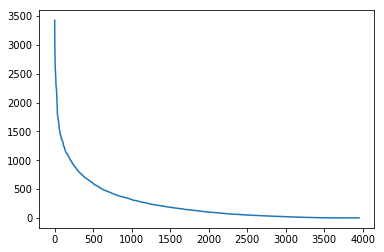

In [3]:
def veiwMovieData(dataset):
    n_users  = np.max(dataset[:,0])
    n_items  = np.max(dataset[:,1])
    avgS     = round(len(dataset) / n_items, 0)
    itemFreq = [0 for x in range(n_items)]
    for record in dataset:
        itemFreq[record[1]-1] += 1
    realHH = set()
    for i,n in enumerate(itemFreq):
        if n >= avgS:
            realHH.add(i+1)
    itemFreq.sort(reverse=True)
    plt.plot(range(len(itemFreq)), itemFreq)
    print("number of items: ", n_items)
    print("number of flows: ", len(dataset))
    print("avg of S(x): ", avgS)
    print("parameter phi: ", round(1 / n_items, 5))
    print("parameter epsilon should less than or equal phi")
    print("sketch belongs to half of the stream")
    return realHH

realHH_movie = veiwMovieData(dataset)

number of items:  6040
number of flows:  1000209
avg of S(x):  166.0
parameter phi:  0.00017
parameter epsilon should less than or equal phi
sketch belongs to half of the stream


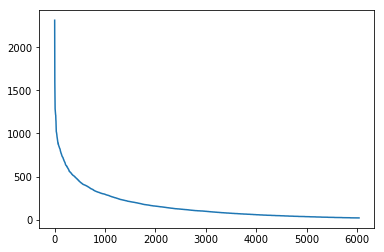

In [4]:
def veiwUserData(dataset):
    n_users  = np.max(dataset[:,0])
    n_items  = np.max(dataset[:,1])
    avgS     = round(len(dataset) / n_users, 0)
    userFreq = [0 for x in range(n_users)]
    for record in dataset:
        userFreq[record[0]-1] += 1
    realHH = set()
    for i,n in enumerate(userFreq):
        if n >= avgS:
            realHH.add(i+1)
    userFreq.sort(reverse=True)
    plt.plot(range(len(userFreq)), userFreq)
    print("number of items: ", n_users)
    print("number of flows: ", len(dataset))
    print("avg of S(x): ", avgS)
    print("parameter phi: ", round(1 / n_users, 5))
    print("parameter epsilon should less than or equal phi")
    print("sketch belongs to half of the stream")
    return realHH

realHH_user = veiwUserData(dataset)

In [5]:
phi_movie = 0.00025
phi_user = 0.00017
S = len(dataset)
delta   = 0.05
epsilon = 0.002
r = round(np.log2(1 / delta)).astype(np.int)
w = round(2 / epsilon)
print("r =", r)
print("w =", w)

r = 4
w = 1000


In [6]:
def initSketch(sketch_deep, sketch_width):
    sketch = [[(0,0,0) for x in range(sketch_width)] for y in range(sketch_deep)]
    return sketch
movie_sketch = initSketch(r, w)
user_sketch = initSketch(r, 2*w)

In [7]:
def update(sketch, item):
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    x  = item[0]
    vx = item[1]
    for i in range(sketch_deep):
        np.random.seed(i + x)
        j = np.random.choice(sketch_width)
        V = sketch[i][j][0] + vx
        K = sketch[i][j][1]
        C = sketch[i][j][2]
        if K == x:
            C += vx
        else:
            C -= vx
            if C < 0:
                K = x
                C = -C
        sketch[i][j] = (V, K, C)
    return sketch

In [8]:
def processStream_HH(sketch, dataset, i):
    for record in dataset:
        item = (record[i], 1)
        update(sketch,item)
    return 

data = dataset[dataset[:,2].argsort()]
processStream_HH(movie_sketch, data, 1)
processStream_HH(user_sketch, data, 0)

In [9]:
def queryU(sketch, x):
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    res_list = list()
    for i in range(sketch_deep):
        np.random.seed(i + x)
        j = np.random.choice(sketch_width)
        V = sketch[i][j][0]
        K = sketch[i][j][1]
        C = sketch[i][j][2] 
        if K == x:
            S = (V + C) / 2
        else:
            S = (V - C) / 2
        res_list.append(S)
    return min(res_list)

In [10]:
def queryU(sketch, x):
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    res_list = list()
    for i in range(sketch_deep):
        np.random.seed(i + x)
        j = np.random.choice(sketch_width)
        V = sketch[i][j][0]
        K = sketch[i][j][1]
        C = sketch[i][j][2] 
        if K == x:
            S = (V + C) / 2
        else:
            S = (V - C) / 2
        res_list.append(S)
    return min(res_list)

In [11]:
def queryL(sketch, x):
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    res_list = list()
    for i in range(sketch_deep):
        np.random.seed(i + x)
        j = np.random.choice(sketch_width)
        K = sketch[i][j][1]
        C = sketch[i][j][2] 
        if K == x:
            S = C
        else:
            S = 0
        res_list.append(S)
    return max(res_list)

In [12]:
def hitter(sketch, phi, S):
    print("heavy hitter threshold: ", phi * S)
    hh = dict()
    sketch_deep  = len(sketch)
    sketch_width = len(sketch[0])
    for i in range(sketch_deep):
        for j in range(sketch_width):
            if sketch[i][j][0] >= phi * S:
                x = sketch[i][j][1]
                ecount = queryU(sketch, x)
                if ecount >= phi * S:
                    if x not in hh:
                        hh[x] = ecount
                    else:
                        if hh[x] > ecount:
                            hh[x] = ecount
    return hh

In [13]:
resHH_movie = hitter(movie_sketch, phi_movie, S)
resHH_user = hitter(user_sketch, phi_user, S)

heavy hitter threshold:  250.05225000000002
heavy hitter threshold:  170.03553000000002


In [14]:
def evaluate(res, real):
    tp = fp = fn = 0
    for i in res:
        if i in real:
            tp += 1
        else:
            fp += 1
    for j in real:
        if j not in res:
            fn += 1
    print("TP =",tp,"   FP =", fp,"   FN =", fn)
    recall = tp / (tp + fn)
    print('reacall:', recall)
    precision = tp / (tp + fp)
    print('precision:',precision)
    f1 = (2 * recall * precision) / (precision + recall)
    print('F1-score:',f1)

In [15]:
evaluate(set(resHH_movie.keys()), realHH_movie)
evaluate(set(resHH_user.keys()), realHH_user)

TP = 1115    FP = 45    FN = 91
reacall: 0.9245439469320066
precision: 0.9612068965517241
F1-score: 0.9425190194420964
TP = 1726    FP = 93    FN = 166
reacall: 0.912262156448203
precision: 0.9488730071467839
F1-score: 0.9302074912422527


In [16]:
def getTopK(resHH, K=8):
    return np.array(heapq.nlargest(K, resHH.items(), lambda d: d[1]),dtype=int)

In [23]:
movieK = 8
userK  = 20
movieTopK = pd.DataFrame(getTopK(resHH_movie, movieK), columns=['mid','ecount'])
userTopK = pd.DataFrame(getTopK(resHH_user, userK), columns=['uid','ecount'])

In [24]:
movieTopK.to_csv("./service/Movie_TopK.csv", index=None)

In [25]:
userTopK.to_csv("./service/User_TopK.csv", index=None)